In [24]:
import numpy as np

class SimpleGRU:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases
        self.W_z = np.random.randn(hidden_size, input_size)
        self.U_z = np.random.randn(hidden_size, hidden_size)
        self.b_z = np.zeros((hidden_size, 1))
        
        self.W_r = np.random.randn(hidden_size, input_size)
        self.U_r = np.random.randn(hidden_size, hidden_size)
        self.b_r = np.zeros((hidden_size, 1))
        
        self.W_h = np.random.randn(hidden_size, input_size)
        self.U_h = np.random.randn(hidden_size, hidden_size)
        self.b_h = np.zeros((hidden_size, 1))
        
        self.W_y = np.random.randn(output_size, hidden_size)
        self.b_y = np.zeros((output_size, 1))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def tanh(self, x):
        return np.tanh(x)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x))
        return exp_x / exp_x.sum(axis=0, keepdims=True)

    def forward(self, x):
        T = len(x)
        h = np.zeros((self.hidden_size, 1))  # Initialize hidden state as column vector
        y_list = []
        h_list = []  # Store hidden states
    
        for t in range(T):
            x_t = x[t].reshape(-1, 1)  # Reshape input to column vector
    
            # Update gate
            z = self.sigmoid(np.dot(self.W_z, x_t) + np.dot(self.U_z, h) + self.b_z)
    
            # Reset gate
            r = self.sigmoid(np.dot(self.W_r, x_t) + np.dot(self.U_r, h) + self.b_r)
    
            # Candidate hidden state
            h_tilde = self.tanh(np.dot(self.W_h, x_t) + np.dot(self.U_h, r * h) + self.b_h)
    
            # Hidden state update
            h = (1 - z) * h + z * h_tilde
    
            # Output
            y = np.dot(self.W_y, h) + self.b_y  # h is now of shape (hidden_size, 1)
            y_list.append(y)
            h_list.append(h)  # Save the hidden state
    
        return y_list, h_list  # Return both outputs and hidden states


    def backward(self, x, y_list, target, h_list):
        T = len(x)
        dW_z = np.zeros_like(self.W_z)
        dU_z = np.zeros_like(self.U_z)
        db_z = np.zeros_like(self.b_z)
        
        dW_r = np.zeros_like(self.W_r)
        dU_r = np.zeros_like(self.U_r)
        db_r = np.zeros_like(self.b_r)
        
        dW_h = np.zeros_like(self.W_h)
        dU_h = np.zeros_like(self.U_h)
        db_h = np.zeros_like(self.b_h)
        
        dW_y = np.zeros_like(self.W_y)
        db_y = np.zeros_like(self.b_y)
        
        dh_next = np.zeros_like(h_list[0])
    
        for t in reversed(range(T)):
            h = h_list[t]  # Get the hidden state for time step t
    
            dy = y_list[t] - target[t].reshape(-1, 1)  # Ensure target is reshaped to match y_list
    
            dW_y += np.dot(dy, np.transpose(h))  # dy shape: (output_size, 1), h shape: (hidden_size, 1)
            db_y += dy
    
            dh = np.dot(np.transpose(self.W_y), dy) + dh_next  # dh shape must match hidden state
    
            # Proceed with other gradients (not shown here)...
            # You'll need to propagate the gradients through the GRU components (z, r, h_tilde)
    
            dh_next = dh  # Update for next time step
            
        return dW_z, dU_z, db_z, dW_r, dU_r, db_r, dW_h, dU_h, db_h, dW_y, db_y



    def update_parameters(self, dW_z, dU_z, db_z, dW_r, dU_r, db_r, dW_h, dU_h, db_h, dW_y, db_y, learning_rate):
        self.W_z -= learning_rate * dW_z
        self.U_z -= learning_rate * dU_z
        self.b_z -= learning_rate * db_z
        
        self.W_r -= learning_rate * dW_r
        self.U_r -= learning_rate * dU_r
        self.b_r -= learning_rate * db_r
        
        self.W_h -= learning_rate * dW_h
        self.U_h -= learning_rate * dU_h
        self.b_h -= learning_rate * db_h
        
        self.W_y -= learning_rate * dW_y
        self.b_y -= learning_rate * db_y

# Example usage
input_size = 4
hidden_size = 3
output_size = 2

gru = SimpleGRU(input_size, hidden_size, output_size)

# Generate random data
sequence_length = 5
data = [np.random.randn(input_size) for _ in range(sequence_length)]
target = [np.random.randn(output_size) for _ in range(sequence_length)]

# Forward pass
y_list, h_list = gru.forward(data)

# Backward pass (pass both y_list and h_list)
dW_z, dU_z, db_z, dW_r, dU_r, db_r, dW_h, dU_h, db_h, dW_y, db_y = gru.backward(data, y_list, target, h_list)


# Update weights and biases
learning_rate = 0.1
gru.update_parameters(dW_z, dU_z, db_z, dW_r, dU_r, db_r, dW_h, dU_h, db_h, dW_y, db_y, learning_rate)


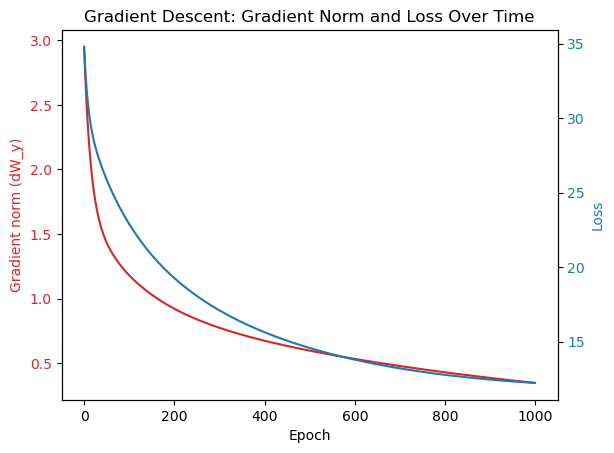

In [25]:
import matplotlib.pyplot as plt

# Initialize lists to store gradients for plotting
dW_y_values = []
loss_values = []

# Training loop (add gradient tracking)
num_epochs = 1000  # Adjust the number of training iterations

for epoch in range(num_epochs):
    # Forward pass
    y_list, h_list = gru.forward(data)

    # Compute loss (assuming squared error loss)
    loss = np.sum([(y_list[t] - target[t])**2 for t in range(len(target))])
    loss_values.append(loss)
    
    # Backward pass
    dW_z, dU_z, db_z, dW_r, dU_r, db_r, dW_h, dU_h, db_h, dW_y, db_y = gru.backward(data, y_list, target, h_list)

    # Store the norm of dW_y (you can track other gradients similarly)
    gradient_norm = np.linalg.norm(dW_y)
    dW_y_values.append(gradient_norm)
    
    # Update weights (simplified gradient descent step, adjust learning rate)
    learning_rate = 0.01
    gru.W_y -= learning_rate * dW_y
    gru.b_y -= learning_rate * db_y

# Plot the gradients and loss over time
fig, ax1 = plt.subplots()

# Plot the gradient norm (y-axis on the left)
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Gradient norm (dW_y)', color=color)
ax1.plot(range(num_epochs), dW_y_values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a second y-axis for the loss plot
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Loss', color=color)
ax2.plot(range(num_epochs), loss_values, color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and display
plt.title('Gradient Descent: Gradient Norm and Loss Over Time')
plt.show()
